# Spike shape

author: laquitainesteeve@gmail.com

Purpose: describe ground truth action potential shapes with WaveMap clustering for biophysical evoked neuropixel demo.

Execution time: 2 mins

Special hardware: on CPU, does not require GPU.

Required resources:
- RAM: 184 GB

METHOD:
- selected sorted single-units only
- new: PEAK_SIGN is 'neg' rather than 'both' when generating templates to find the nearest site.
- new: aligned each sorted unit waveforms based on their negative peak (trough) searched in a short window of 2.5 ms surrounding the trough, to prevent waveform collisions.
- template: 
    - default average waveforms
    - not calculated with spikeinterface but inspired from Lee et al 2021 (filtering waveforms within 2 std of the mean to calculate the mean).This made the average waveform (template) more robust to outlier waveforms and more representative to the majority of observed waveforms. We did not used a absolute deviation of 0.4 which discarded to many units that seem reliable.
- new: to increase the unit sample size, we now pool npx_evoked sorted units with npx_spont units.

## Setup

Create, activate and select virtual environment kernel `demo` from (envs/demo.yml):

```bash
python -m ipykernel install --user --name demo --display-name "demo" # create kernel
```

In [ ]:
%%time
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# import packages
import os
import shutil
import numpy as np
from dandi.dandiapi import DandiAPIClient
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
from spikeinterface import extract_waveforms
import spikeinterface.core.template_tools as ttools
from spikeinterface.core.sparsity import compute_sparsity
from matplotlib import pyplot as plt;
import multiprocessing
import torch
import pandas as pd
import seaborn as sns
import matplotlib
import sys
from scipy.stats import kruskal
import scikit_posthocs as sp
import sklearn
from concurrent.futures import ProcessPoolExecutor
import multiprocessing as mp # set context "fork" for macOS or "spawn"
import random 
from umap import umap_ as umap
import networkx as nx
import community as community_louvain
from collections import Counter
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

print("spikeinterface version:", si.__version__)

# project path
proj_path = "/home/steeve/steeve/epfl/code/spikebias/"
os.chdir(proj_path)

# import spikebias package
from src.nodes.utils import get_config, demean
from src.nodes.validation import snr
from src.nodes.validation import amplitude, power_demo, power


# setup dataset paths
# npx_spont
RECORDING_NS_PATH = 'dataset/00_raw/recording_npx_spont'
SORTING_NS_KS3_PATH = 'dataset/01_intermediate/sorting/npx_spont/SortingKS3'

# npx_evoked
RECORDING_E_PATH = 'dataset/00_raw/recording_npx_evoked'
SORTING_E_KS3_PATH = 'dataset/01_intermediate/sorting/npx_evoked/SortingKS3'


# setup recording preprocessing parameters
DURATION_SEC = 600
FREQ_MIN = 300
FREQ_MAX = 3000
REFERENCE = "global"
OPERATOR = "median"


# setup waveform parameters
N_JOBS = 20                 # (default = 20) number of parallel processes for waveform extraction (20/32)
CHUNKS = 50000              # (default = 800000) use smaller chunks to use less RAM
JOB_KWARGS = dict(n_jobs=N_JOBS, chunk_size=800000, progress_bar=True)   # 20/32 cores
PEAK_SIGN = "neg"
EXT_PARAMS = {'waveforms': {'ms_before': 6.0, 'ms_after': 6.0}, 
              'templates': {'operators': ['average', 'std'], 'ms_before': 6.0, 'ms_after': 6.0},
              'random_spikes': {'seed': 0}}
WAVE_PATH = os.path.join(proj_path + "temp/waveforms/npx_spont/SortingKS3")
METHOD = 'radius'          # compute sparse waveforms within radius of the nearest electrode
RADIUS_UM = 50             # compute sparse waveforms radius

# setup template parameters
# these make the average waveform (template) more robust to outlier waveforms
# and more representative to the majority of observed waveforms
ABS_DEV = np.inf     # (default=0.4) as in lee et al 2021's wavemap paper
N_STD_OF_MEAN = 2    # (default=2) as in lee et al 2021's wavemap paper

# setup cortical layer parameter
lyrs = ["L5"]
prm = dict()
prm["SFREQ_NS"] = 40000  # sampling frequency
prm["SFREQ_NE"] = 20000

# wavemap parameters
N_SITES = 5
RAND_STATE = 42
colors = np.array( # waveform shape profile colors
    [
        [0.9, 0.7, 0.3],  # yellow/gold
        [0.8, 0.70, 0.2],  # lighter yellow/green
        [0.8, 0.75, 0.2],  # lightest yellow/green
        [1, 0, 0],  # red
        [0.33, 0.29, 0.58],  # purple blue
        [0.44, 0.65, 0.79],  # light blue
        [0.54, 0.75, 0.89],  # lighter blue
        [0.64, 0.85, 0.99],  # lightest blue
        [254 / 255, 235 / 255, 226 / 255],  # purple variation
        [252 / 255, 197 / 255, 192 / 255],  # purple variation
        [250 / 255, 159 / 255, 181 / 255],  # purple variation
        [247 / 255, 104 / 255, 161 / 255],  # purple variation
        [221 / 255, 52 / 255, 151 / 255],  # purple variation
        [174 / 255, 1 / 255, 126 / 255],  # purple variation
    ]
)

# plot parameters
FIG_SIZE = (1.5, 1.5)
cl = dict()
cl["COLOR_NS"] = [0.9, 0.14, 0.15]
cl["COLOR_NE"] = [1, 0.49, 0] # orange
cl["COLOR_MEDIAN"] = (1, 0.76, 0)

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 14  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
N_MAJOR_TICKS = 4
N_MINOR_TICKS = 12
savefig_cfg = {"transparent":True, "dpi":300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame

FIG_SIZE = (1, 1)
pm = {
    "linestyle": "None",
    "marker": "o",
    "markersize": 1.5,
    "rasterized": True,
    "markeredgecolor": "w",
    "markeredgewidth": 0.06,
}
pm_fit1 = {
    "linestyle": "-",
    "linewidth": 0.5,
    "color": "k",
}
pm_fit2 = {
    "linestyle": "-",
    "linewidth": 0.5,
    "color": "k",
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
spikeinterface version: 0.101.2
CPU times: user 508 μs, sys: 0 ns, total: 508 μs
Wall time: 464 μs


## Functions

In [677]:
# def get_max_site_id(analyzer, cell_id, peak_sign="neg"):
#     """get index of max site id, among the sparse subset of 
#     sites used for the waveform
    
#     Returns:
#         nearest site index
#         nearest site id
#     """

#     # find nearest site to each cell
#     max_chids = ttools.get_template_extremum_channel(
#         analyzer, peak_sign=peak_sign
#     )
    
#     # get the ids of the subset of surrounding sites (sparse)
#     c_ids = analyzer.sparsity.unit_id_to_channel_ids[cell_id].astype(int)

#     # get the nearest site (default to largest 
#     # negative peak (trough))
#     max_chid = int(max_chids[cell_id])
#     try:
#         nearest_site_ix = np.where(c_ids == max_chid)[0][0]
#     except: 
#         from ipdb import set_trace; set_trace()
#     return nearest_site_ix, max_chids[cell_id]


def get_nearest_site(templates_by_site):
    trough_amplitude = np.nanmin(templates_by_site, axis=1)
    
    # catch exception
    if np.isnan(trough_amplitude).all():
        index = None
    else: 
        index = np.nanargmin(np.nanmin(templates_by_site, axis=1))        
    # if not np.isfinite(index):
    #     index = None
    return index


# def _get_waveforms_for(cell_id, analyzer, waveform_extension, peak_sign='neg'):
    
#     # get the waveforms at each site (spikes, time, sites)
#     waves = waveform_extension.get_waveforms_one_unit(unit_id=cell_id)

#     # get the nearest site to the cell
#     nearest_site_ix, nearest_site_id = get_max_site_id(analyzer, cell_id, peak_sign)
#     return waves, nearest_site_ix, nearest_site_id


def get_waveforms_for(cell_id, waveform_extension):
    return waveform_extension.get_waveforms_one_unit(unit_id=cell_id)


def align_by_neg_peak_and_crop(waves, sampling_frequency, window=100, peak_pos=50):
    """
    W: array of shape (n_waveforms, n_samples) e.g. (N, 480)
    window: number of samples in the output window (e.g. 100)
    peak_pos: index in [0, window-1] where the negative peak will be placed (e.g. 50)
    fill_value: value used when the 100-sample window would run beyond the edges
    Returns: array of shape (n_waveforms, window)
    """
    
    # find peak index in shortened waveform
    # shorten waveform to find peak without spike collision
    short_waves, wind_start, wind_end = shorten_waveform(waves, window_sec=2.5, sampling_freq=sampling_frequency)

    num_waves, _ = short_waves.shape
    left = peak_pos
    right = window - left  # number of samples to include to the right of the peak
    aligned = np.full((num_waves, window), np.nan, dtype=short_waves.dtype) # placeholder of nans

    # index of negative peak for each waveform
    trough_idx = np.argmin(short_waves, axis=1)

    # locate peak index in longer waveforms
    trough_idx = trough_idx + wind_start

    # number of timepoints in longer waves
    n_timepoints = waves.shape[1]

    for w_ix in range(num_waves):

        # desired window in original signal: [p-left, p+right)
        src_start = max(0, trough_idx[w_ix] - left)
        src_end   = min(n_timepoints, trough_idx[w_ix] + right)
        
        # where to place it in the output (shift if we clipped at edges)
        dst_start = max(0, left - trough_idx[w_ix])          # how many samples we clipped on the left
        dst_end   = dst_start + (src_end - src_start)

        # align
        aligned[w_ix, dst_start:dst_end] = waves[w_ix, src_start:src_end]
    return aligned


def shorten_waveform(waveforms: np.array, window_sec=2.5, sampling_freq=40000):

    # calculate shorter window
    sample_sec = (1/sampling_freq) * 1000
    shorter_window = int(window_sec / sample_sec)

    # get shorter window
    mid_point = int(waveforms.shape[1] / 2 )
    wind_start = int(mid_point - shorter_window/2)
    wind_end =  int(mid_point + shorter_window/2)
    shorter_window_sample = np.arange(wind_start, wind_end, 1).astype(int)
    return waveforms[:, shorter_window_sample], wind_start, wind_end


def get_single_unit_ids(Sorting):
    single_unit_ix = np.where(Sorting.get_property('KSLabel') == 'good')[0]
    return Sorting.unit_ids[single_unit_ix]


def filter_best_set_of_waves_for_the_mean(waves, n_std_of_mean=2, abs_dev=0.4):
    """see wavemap paper 
    DOI: https://doi.org/10.7554/eLife.67490

    Args:    
        waves (np.array): (n_waveforms, n_timepoints)
        
    Returns:
        selected_waves
        selected_indices
    """

    # mean and per-time-point std of the waveforms
    mean_wave = waves.mean(axis=0)
    std_wave = waves.std(axis=0)  # ddof=0 (population). Use ddof=1 if you prefer sample std.

    # Avoid divide-by-zero where a time point has zero variance
    std_safe = np.where(std_wave == 0, 1.0, std_wave)

    # Condition A: every time point is within ±2 std of the mean (pointwise)
    z = (waves - mean_wave) / std_safe
    within_2std = np.all(np.abs(z) <= n_std_of_mean, axis=1)

    # Condition B: average absolute deviation from the mean across time < 0.4
    avg_abs_dev = np.mean(np.abs(waves - mean_wave), axis=1)
    low_avg_dev = avg_abs_dev < abs_dev

    # Final selection
    mask = within_2std & low_avg_dev
    selected_indices = np.flatnonzero(mask)
    selected_waves = waves[mask]
    return selected_waves, selected_indices


def calculate_template(cell_id, analyzer, wave_ext, sfreq, peak_sign='neg', window=100, peak_pos=50, n_std_of_mean=2, abs_dev=0.4):
    """_summary_

    Args:
        cell_id (int): _description_
        analyzer (_type_): _description_
        wave_ext (_type_): _description_
        sfreq (int): recording sampling frequency
        peak_sign (str, optional): _description_. Defaults to 'neg'
        window (int): number of timepoints of produced template
        peak_pos: index of the trough in the produced template
        n_std_of_mean (int): for filtering best waveforms - see wavemap paper
        abs_dev (float): for filtering best waveforms - see wavemap paper

    Returns:
        dict: 
        - 'templates': templates for the cell's nearby sites of shape (n_sites, n_timepoints)
    """
    # get waveforms and the index of the nearest site
    #waves, _, _ = _get_waveforms_for(cell_id, analyzer, wave_ext, peak_sign=peak_sign)
    waves = get_waveforms_for(cell_id, wave_ext)

    # get number of nearby sites
    _, _, n_sites = waves.shape

    templates = []

    for site_ix in range(n_sites):
        
        # align waveforms
        aligned = align_by_neg_peak_and_crop(waves[:,:,site_ix], sfreq, window=window, peak_pos=peak_pos)

        # filter the best waveforms to calculate a reliable template
        filtered, _ = filter_best_set_of_waves_for_the_mean(aligned, n_std_of_mean=n_std_of_mean, abs_dev=abs_dev)
        
        # calculate template
        templates.append(np.nanmean(filtered, axis=0))
    
    templates = np.array(templates)

    # get nearby site ids
    site_ids = analyzer.sparsity.unit_id_to_channel_ids[cell_id]

    # get nearest sites (found within sparse nearby sites)
    nearest_site_ix = get_nearest_site(templates)
    nearest_site_id = site_ids[nearest_site_ix]

    return {'templates': templates, 
            'nearest_site_index': nearest_site_ix, 
            'nearest_site_id': nearest_site_id, 
            'nearby_site_ids': site_ids}


def apply_wavemap(downsampled_nearest_site_templates, rand_state):

    # setup reproducibility
    np.random.seed(rand_state)
    os.environ["PYTHONHASHSEED"] = str(rand_state)
    random.seed(rand_state)

    # normalize waveforms between 0 and 1.
    #normalized = sklearn.preprocessing.normalize(downsampled_nearest_site_templates, norm='max')

    # normalize waveforms between -1 and 1.
    scaler = MinMaxScaler(feature_range=(-1, 1))
    normalized = scaler.fit_transform(downsampled_nearest_site_templates.T).T

    # reduce dimensionality with UMAP (defaults to 2D)
    reducer = umap.UMAP()
    mapper = reducer.fit(normalized)

    # clustering with Louvain
    G = nx.from_scipy_sparse_array(mapper.graph_)
    clustering = community_louvain.best_partition(G)
    clustering_solution = list(clustering.values())

    # create 2D embedding
    embedding = reducer.fit_transform(normalized)

    # get cluster profiles
    umap_df = pd.DataFrame(embedding, columns=("x", "y"))
    umap_df["waveform"] = list(normalized)
    umap_df["cluster_id"] = clustering_solution
    profiles = np.unique(umap_df["cluster_id"])
    print('nb of shape profiles:', len(profiles))
    return normalized, umap_df, profiles


def get_multi_site_templates(templates: np.array, n_sites=6):

    # get indices of n_sites (6) with the largest 
    # trough, in ascending order
    mins = np.min(templates, axis=1)
    neg_idx = np.flatnonzero(mins < 0)
    order = np.argsort(mins[neg_idx])
    sorted_indices = neg_idx[order]
    # return templates for these sites,
    # in ascending order
    return templates[sorted_indices[:n_sites],:]


def plot_embedding(ax, umap_df, profiles, colors):
    
    # plot
    for ix, profile_i in enumerate(profiles):
        ax.scatter(umap_df["x"][umap_df["cluster_id"] == profile_i].tolist(),
            umap_df["y"][umap_df["cluster_id"] == profile_i].tolist(),
            marker="o", color=colors[ix], label=profile_i, s=10)

    # aesthetics
    ax.spines[["top", "right"]].set_visible(False)
    ax.set_ylabel("Feature 1 (a.u)")
    ax.set_xlabel("Feature 2 (a.u)")

    # legend
    ax.legend(fontsize=20, bbox_to_anchor=(1, 1.1), **{"frameon": False, "handletextpad": 0.1})
    return ax 


def plot_profiles(ax, normWFs, umap_df, profiles, colors):

    # plot templates per shape profile
    for ix in range(len(profiles)):
        ax[ix].plot(normWFs[umap_df["cluster_id"] == ix].T, color=colors[ix], alpha=0.5, linewidth=1);
        ax[ix].set_title(str(ix))
    return ax


def get_multi_site_templates_for_wavemap(templates_dict, n_sites=6):
    
    # get multi-site templates
    multi_sites_templates = []
    unit_ids = []
    for ix, unit_id in tqdm(enumerate(templates_dict)):
        
        templates = templates_dict[unit_id]['templates']

        # catch exception
        if (templates.shape[0] >= n_sites) and (not np.isnan(templates).any()):
            tmp = get_multi_site_templates(templates, n_sites=n_sites)
            multi_sites_templates.append(tmp)
            unit_ids.append(unit_id)
    
    multi_sites_templates = np.array(multi_sites_templates) # (n_units, n_sites (=6), n_timepoints)
    multi_sites_templates = multi_sites_templates[:,:,::2] # downsample waveforms to 50 timepoints

    # create scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))

    # normalize each site's waveform between -1 and 1
    # make an array (n_units, n_sites (=6), n_timepoints)        
    normalized = []
    for ix in range(multi_sites_templates.shape[0]):
        normalized.append(scaler.fit_transform(multi_sites_templates[ix,:,:].T).T)
    multi_sites_templates = np.array(normalized) 
    
    # concatenate waveforms across sites per unit
    return multi_sites_templates.reshape(multi_sites_templates.shape[0],-1), unit_ids 


## Load datasets

In [471]:
%%time 

# load npx_spont recordingg and sorting extractors
RecordingNS = si.load_extractor(RECORDING_NS_PATH)
RecordingNS = RecordingNS.frame_slice(start_frame=0, end_frame=RecordingNS.sampling_frequency * DURATION_SEC)
print('Recording:', RecordingNS)

SortingNS = si.load_extractor(SORTING_NS_KS3_PATH)
SortingNS = SortingNS.frame_slice(start_frame=0, end_frame=SortingNS.sampling_frequency * DURATION_SEC)
print('Sorting:', SortingNS)

single_units_ns = get_single_unit_ids(SortingNS)
print('nb of single units:', len(single_units_ns))

Recording: FrameSliceRecording: 384 channels - 40.0kHz - 1 segments - 24,000,000 samples 
                     600.00s (10.00 minutes) - float32 dtype - 34.33 GiB
Sorting: FrameSliceSorting: 1684 units - 1 segments - 40.0kHz
nb of single units: 335
CPU times: user 15.8 ms, sys: 3.74 ms, total: 19.6 ms
Wall time: 32.9 ms


In [472]:
%%time 

# load npx_evoked recording and sorting extractors
RecordingE = si.load_extractor(RECORDING_E_PATH)
RecordingE = RecordingE.frame_slice(start_frame=0, end_frame=RecordingE.sampling_frequency * DURATION_SEC)
print('Recording:', RecordingE)

SortingE = si.load_extractor(SORTING_E_KS3_PATH)
SortingE = SortingE.frame_slice(start_frame=0, end_frame=SortingE.sampling_frequency * DURATION_SEC)
print('Sorting:', SortingE)

single_units_e = get_single_unit_ids(SortingE)
print('nb of single units:', len(single_units_e))

Recording: FrameSliceRecording: 384 channels - 20.0kHz - 1 segments - 12,000,000 samples 
                     600.00s (10.00 minutes) - float32 dtype - 17.17 GiB
Sorting: FrameSliceSorting: 1660 units - 1 segments - 20.0kHz
nb of single units: 384
CPU times: user 11 ms, sys: 3.05 ms, total: 14.1 ms
Wall time: 16.1 ms


## Compute waveforms

- Execution time: 15 min

In [473]:
%%time 

# npx_spont

# band-pass filter, reference and whiten voltage traces (as in Kilosort)
RecordingNS = spre.bandpass_filter(RecordingNS, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
RecordingNS = spre.common_reference(RecordingNS, reference=REFERENCE, operator=OPERATOR)
RecordingNS = spre.whiten(RecordingNS, dtype='float32') # requires float

# extract waveforms for the sites within <50> um to each sorted cell
# display parameters with: analyzer.get_extension(extension_name="templates").params
AnalyzerNS = si.create_sorting_analyzer(sorting=SortingNS, recording=RecordingNS, format="memory", sparse=True)
AnalyzerNS.compute(['random_spikes', 'waveforms', 'templates'], extension_params=EXT_PARAMS, save=False)
#AnalyzerNS.sparsity = compute_sparsity(templates_or_sorting_analyzer=AnalyzerNS, method="best_channels", num_channels=N_NEARBY_SITES)
AnalyzerNS.sparsity = compute_sparsity(templates_or_sorting_analyzer=AnalyzerNS, method=METHOD, radius_um=RADIUS_UM) # recommended method in spikeinterface
wave_ext_ns = AnalyzerNS.get_extension('waveforms')

compute_waveforms: 100%|##########| 600/600 [05:16<00:00,  1.90it/s]


CPU times: user 48min 44s, sys: 1h 10min 30s, total: 1h 59min 15s
Wall time: 10min 29s


In [ ]:
%%time 

# npx_evoked

# band-pass filter, reference and whiten voltage traces (as in Kilosort)
RecordingE = spre.bandpass_filter(RecordingE, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
RecordingE = spre.common_reference(RecordingE, reference=REFERENCE, operator=OPERATOR)
RecordingE = spre.whiten(RecordingE, dtype='float32')

# extract waveforms for the sites within <50> um to each sorted cell
AnalyzerE = si.create_sorting_analyzer(sorting=SortingE, recording=RecordingE, format="memory", sparse=True)
AnalyzerE.compute(['random_spikes', 'waveforms', 'templates'], extension_params=EXT_PARAMS, save=False)
#AnalyzerE.sparsity = compute_sparsity(templates_or_sorting_analyzer=AnalyzerE, method="best_channels", num_channels=N_NEARBY_SITES)
AnalyzerE.sparsity = compute_sparsity(templates_or_sorting_analyzer=AnalyzerE, method=METHOD, radius_um=RADIUS_UM) # recommended method in spikeinterface
wave_ext_e = AnalyzerE.get_extension('waveforms')

- Execution time: 1 min (335 sorted units)

## Compute templates

- Execution time: 2 min

In [620]:
%%time

# npx_spont

# calculate the templates on (30) nearby sites for each unit
templates_dict_ns = dict()
for _, unit_id in tqdm(enumerate(single_units_ns)):
    templates_dict_ns[unit_id] = calculate_template(unit_id, AnalyzerNS, wave_ext_ns, RecordingNS.sampling_frequency, peak_sign=PEAK_SIGN, window=100, peak_pos=50, n_std_of_mean=N_STD_OF_MEAN, abs_dev=ABS_DEV)

0it [00:00, ?it/s]

335it [00:02, 126.46it/s]

CPU times: user 2.64 s, sys: 9.69 ms, total: 2.65 s
Wall time: 2.65 s


In [678]:
%%time

# npx_evoked

# calculate the templates on (30) nearby sites for each unit
templates_dict_e = dict()
for _, unit_id in tqdm(enumerate(single_units_e)):
    templates_dict_e[unit_id] = calculate_template(unit_id, AnalyzerE, wave_ext_e, RecordingE.sampling_frequency, peak_sign=PEAK_SIGN, window=100, peak_pos=50, n_std_of_mean=N_STD_OF_MEAN, abs_dev=ABS_DEV)

0it [00:00, ?it/s]

384it [00:02, 176.82it/s]

CPU times: user 2.17 s, sys: 4.07 ms, total: 2.18 s
Wall time: 2.17 s


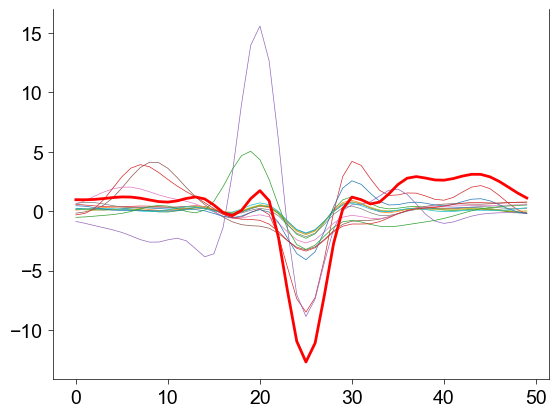

In [672]:
ix = 42

unit_id = single_units_ns[ix]
nearest_site_ix = templates_dict_ns[unit_id]['nearest_site_index']
plt.plot(templates_dict_ns[unit_id]['templates'][:, ::2].T)
plt.plot(templates_dict_ns[unit_id]['templates'][nearest_site_ix, ::2].T, "r", linewidth=2)

## Single-site templates

In [659]:
%%time

# npx_spont

# get each unit's nearest site template
single_site_templates_ns = []
unit_ids_ns = []
for ix, unit_id in tqdm(enumerate(templates_dict_ns)):
    nearest_site_ix = templates_dict_ns[unit_id]['nearest_site_index']
    tmp = templates_dict_ns[unit_id]['templates'][nearest_site_ix,:]
    # catch exception
    if not np.isnan(tmp).any():
        single_site_templates_ns.append(templates_dict_ns[unit_id]['templates'][nearest_site_ix,:])
        unit_ids_ns.append(unit_id)
single_site_templates_ns = np.array(single_site_templates_ns) # (nb_units, n_timepoints)    
single_site_templates_ns = single_site_templates_ns[:,::2]    # downsample to 50 timepoints (see Wavemap paper)

335it [00:00, 451798.02it/s]

CPU times: user 1.77 ms, sys: 641 μs, total: 2.41 ms
Wall time: 2.26 ms


In [679]:
# npx_evoked

# get each unit's nearest site template
single_site_templates_e = []
unit_ids_e = []
for ix, unit_id in tqdm(enumerate(templates_dict_e)):
    nearest_site_ix = templates_dict_e[unit_id]['nearest_site_index']
    tmp = templates_dict_e[unit_id]['templates'][nearest_site_ix,:]
    # catch exception
    if not np.isnan(tmp).any():
        single_site_templates_e.append(templates_dict_e[unit_id]['templates'][nearest_site_ix,:])
        unit_ids.append(unit_id)
single_site_templates_e = np.array(single_site_templates_e) # (nb_units, n_timepoints)    
single_site_templates_e = single_site_templates_e[:,::2]    # downsample to 50 timepoints (see Wavemap paper)

384it [00:00, 392162.83it/s]


## Multi-site templates

In [661]:
%%time

# get templates on 6 nearby sites per unit (n_units, n_timepoints x 6)
multi_sites_templates_ns, unit_ids_ns = get_multi_site_templates_for_wavemap(templates_dict_ns, N_SITES)

335it [00:00, 112326.47it/s]

CPU times: user 39.8 ms, sys: 770 μs, total: 40.6 ms
Wall time: 40 ms


In [680]:
%%time

# get templates on 6 nearby sites per unit (n_units, n_timepoints x 6)
multi_sites_templates_e, unit_ids_e = get_multi_site_templates_for_wavemap(templates_dict_e, N_SITES)

384it [00:00, 120989.54it/s]

CPU times: user 43.2 ms, sys: 917 μs, total: 44.2 ms
Wall time: 43.6 ms


## Wavemap

In [662]:
# npx_spont

# apply wavemap to single-site waveforms
normalized_singlesite_ns, umap_df_singlesite_ns, profiles_singlesite_ns = apply_wavemap(single_site_templates_ns, RAND_STATE)

# apply wavemap to multi-site waveforms
normalized_multisite_ns, umap_df_multisite_ns, profiles_multisite_ns = apply_wavemap(multi_sites_templates_ns, RAND_STATE)

nb of shape profiles: 11
nb of shape profiles: 9


In [681]:
# npx_evoked 

# apply wavemap to single-site waveforms
normalized_singlesite_e, umap_df_singlesite_e, profiles_singlesite_e = apply_wavemap(single_site_templates_e, RAND_STATE)

# apply wavemap to multi-site waveforms
normalized_multisite_e, umap_df_multisite_e, profiles_multisite_e = apply_wavemap(multi_sites_templates_e, RAND_STATE)

nb of shape profiles: 10
nb of shape profiles: 8


## Plot clusters

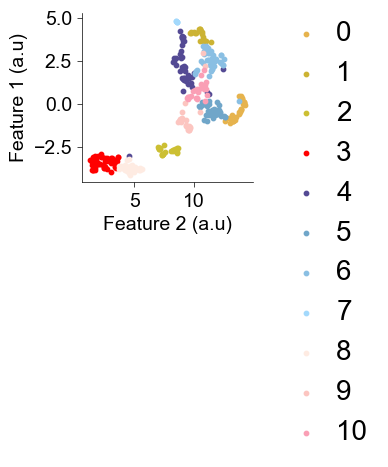

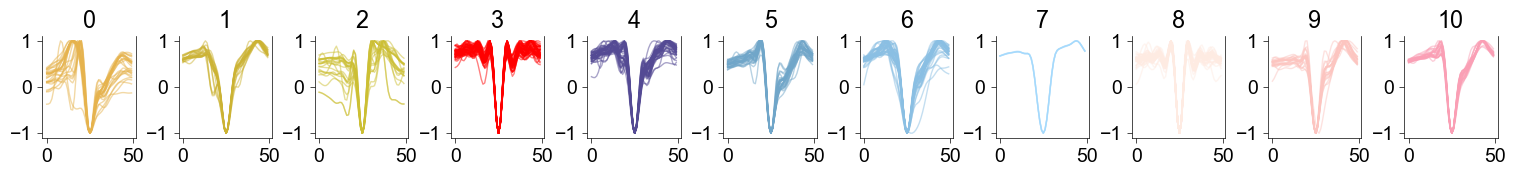

In [684]:
n_profiles = profiles_singlesite_ns[-1] + 1

# setup figure
fig, ax = plt.subplots(1, figsize=(2.2, 2.2))
ax = plot_embedding(ax, umap_df_singlesite_ns, profiles_singlesite_ns, colors)

# setup figure
fig, ax = plt.subplots(1, n_profiles, figsize=(15, 1.6))
ax = plot_profiles(ax, normalized_singlesite_ns, umap_df_singlesite_ns, profiles_singlesite_ns, colors)
fig.tight_layout(pad=0.1)

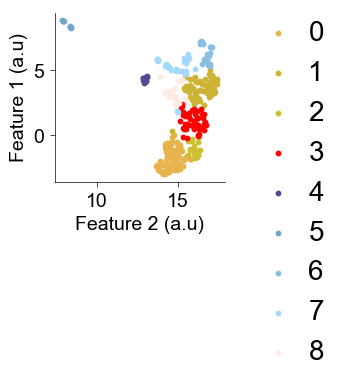

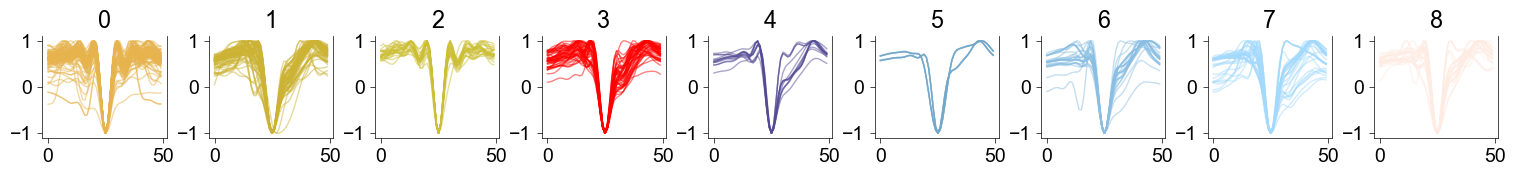

In [685]:
n_profiles = profiles_multisite_ns[-1] + 1

# setup figure
fig, ax = plt.subplots(1, figsize=(2.2, 2.2))
ax = plot_embedding(ax, umap_df_multisite_ns, profiles_multisite_ns, colors)

# setup figure
fig, ax = plt.subplots(1, n_profiles, figsize=(15, 1.6))
ax = plot_profiles(ax, normalized_multisite_ns[:,:50], umap_df_multisite_ns, profiles_multisite_ns, colors)
fig.tight_layout(pad=0.1)

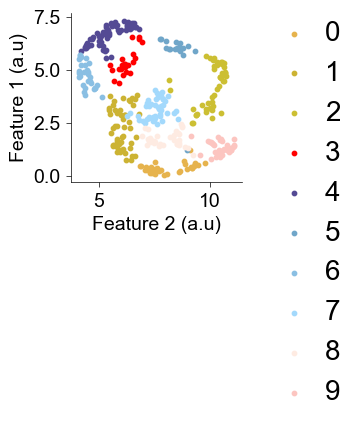

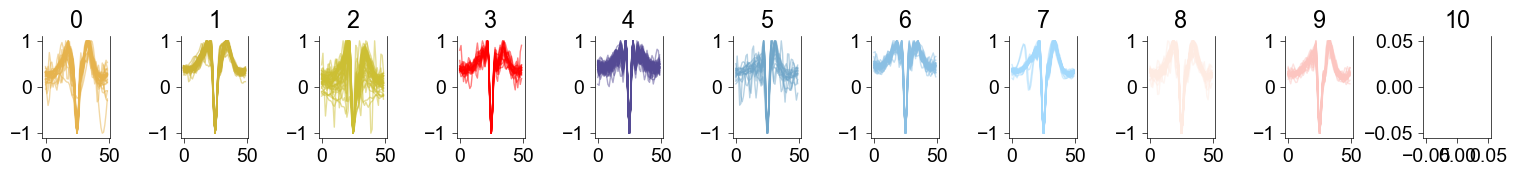

In [682]:
n_profiles = profiles_singlesite_ns[-1] + 1

# setup figure
fig, ax = plt.subplots(1, figsize=(2.2, 2.2))
ax = plot_embedding(ax, umap_df_singlesite_e, profiles_singlesite_e, colors)

# setup figure
fig, ax = plt.subplots(1, n_profiles, figsize=(15, 1.6))
ax = plot_profiles(ax, normalized_singlesite_e, umap_df_singlesite_e, profiles_singlesite_ns, colors)
fig.tight_layout(pad=0.1)

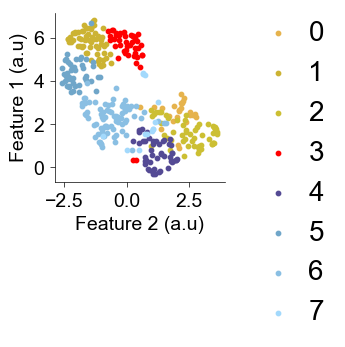

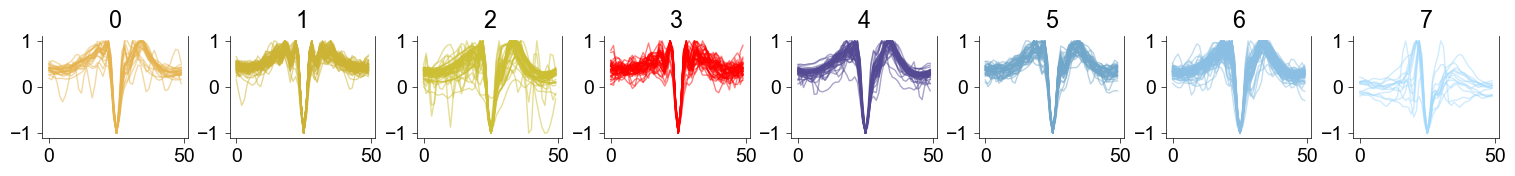

In [683]:
n_profiles = profiles_multisite_e[-1] + 1

# setup figure
fig, ax = plt.subplots(1, figsize=(2.2, 2.2))
ax = plot_embedding(ax, umap_df_multisite_e, profiles_multisite_e, colors)

# setup figure
fig, ax = plt.subplots(1,n_profiles, figsize=(15, 1.6))
ax = plot_profiles(ax, normalized_multisite_e[:,:50], umap_df_multisite_e, profiles_multisite_e, colors)
fig.tight_layout(pad=0.1)

## Plot spike shape clusters

as fig3 Paulk Nat Neurosci 2022

- first site (column) is the site with the largest peak to peak amplitude
- Second site (column) is the site with the second largest peak to peak amplitude

2025-04-07 14:38:54,816 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2025-04-07 14:38:54,915 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2025-04-07 14:38:54,940 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2025-04-07 14:38:54,976 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2025-04-07 14:38

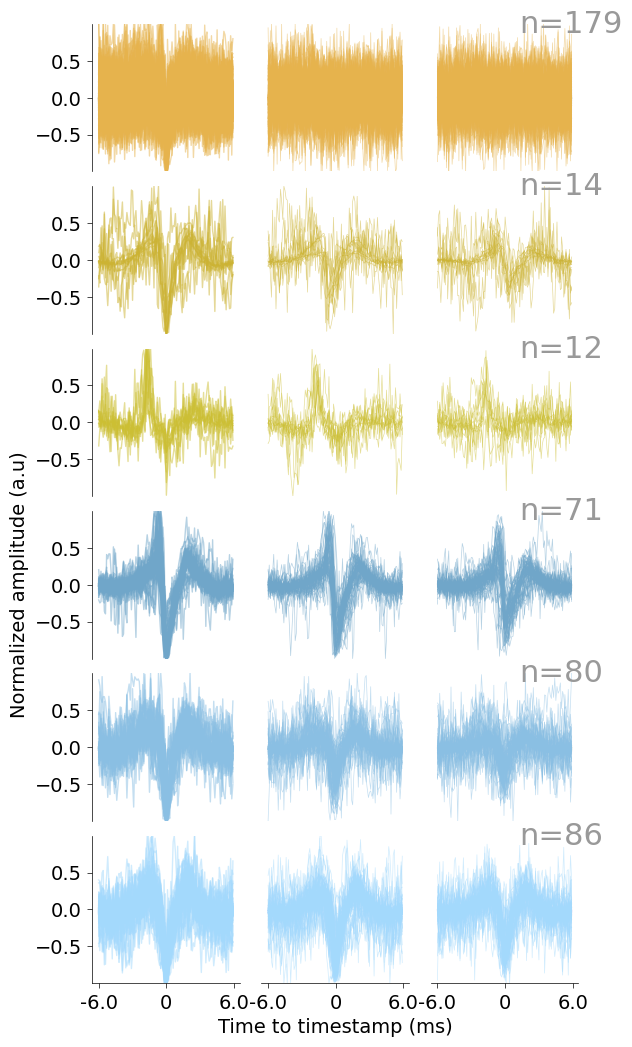

In [63]:
%%time 

counts = Counter(umap_df["cluster_id"])

# order cluster profile panels
profiles = [3, 5, 4, 1, 0, 2]

# spike timestamp locatoon
timestamp_timepoint = SPIKE_PERIOD / 2

# setup figure
fig, axes = plt.subplots(len(profiles), 3, figsize=(5 * 1.5, 7 * 1.5))

YLIM = [-1, 1]

# loop over waveform clusters
for ix, profile_i in enumerate(profiles):

    # site 1
    axes[ix, 0].plot(
        normWFs[umap_df["cluster_id"] == profile_i, :SPIKE_PERIOD].T,
        color=colors[ix],
        alpha=0.5,
        linewidth=1,
    )
    axes[ix, 0].set_box_aspect(1)  # square axis
    axes[ix, 0].spines[["top", "right"]].set_visible(False)
    if not ix == len(profiles) - 1:
        axes[ix, 0].spines[["bottom"]].set_visible(False)
    axes[ix, 0].legend(frameon=False)
    axes[ix, 0].set_yticks([-0.5, 0, 0.5])
    axes[ix, 0].set_ylim(YLIM)
    if ix == 3:
        axes[ix, 0].set_ylabel("Normalized amplitude (a.u)")
    axes[ix, 0].set_xticks([])
    axes[ix, 0].set_xticklabels([])
    if ix == len(profiles) - 1:
        axes[ix, 0].set_xticks([0, timestamp_timepoint, SPIKE_PERIOD])
        axes[ix, 0].set_xticklabels([-MS_BEFORE, 0, MS_AFTER])

    # site 2
    axes[ix, 1].plot(
        normWFs[umap_df["cluster_id"] == profile_i, SPIKE_PERIOD : 2 * SPIKE_PERIOD].T,
        color=colors[ix],
        alpha=0.5,
        linewidth=0.5,
    )
    axes[ix, 1].set_box_aspect(1)  # square axis$
    axes[ix, 1].spines[["top", "right"]].set_visible(False)
    if not ix == len(profiles) - 1:
        axes[ix, 0].spines[["bottom"]].set_visible(False)
    axes[ix, 1].set_yticks([-0.5, 0, 0.5])
    axes[ix, 1].set_ylim(YLIM)
    axes[ix, 1].spines[["left", "right", "top"]].set_visible(False)
    if not ix == len(profiles) - 1:
        axes[ix, 1].spines[["bottom"]].set_visible(False)
    axes[ix, 1].set_yticklabels([])
    axes[ix, 1].set_yticks([])
    axes[ix, 1].set_xticks([0, timestamp_timepoint, SPIKE_PERIOD])
    axes[ix, 1].set_xticklabels([-MS_BEFORE, 0, MS_AFTER])
    axes[ix, 1].set_xticks([])
    axes[ix, 1].set_xticklabels([])
    if ix == len(profiles) - 1:
        axes[ix, 1].set_xticks([0, timestamp_timepoint, SPIKE_PERIOD])
        axes[ix, 1].set_xticklabels([-MS_BEFORE, 0, MS_AFTER])
        axes[ix, 1].set_xlabel("Time to timestamp (ms)")

    # site 3
    axes[ix, 2].plot(
        normWFs[
            umap_df["cluster_id"] == profile_i, 2 * SPIKE_PERIOD : 3 * SPIKE_PERIOD
        ].T,
        color=colors[ix],
        alpha=0.5,
        linewidth=0.5,
    )
    axes[ix, 2].set_box_aspect(1)  # square axis
    axes[ix, 2].set_yticks([-0.5, 0, 0.5])
    axes[ix, 2].set_ylim(YLIM)
    axes[ix, 2].spines[["left", "right", "top"]].set_visible(False)
    if not ix == len(profiles) - 1:
        axes[ix, 2].spines[["bottom"]].set_visible(False)
    axes[ix, 2].set_yticklabels([])
    axes[ix, 2].set_yticks([])
    axes[ix, 2].set_xticks([0, timestamp_timepoint, SPIKE_PERIOD])
    axes[ix, 2].set_xticklabels([-MS_BEFORE, 0, MS_AFTER])
    axes[ix, 2].set_xticks([])
    axes[ix, 2].set_xticklabels([])
    if ix == len(profiles) - 1:
        axes[ix, 2].set_xticks([0, timestamp_timepoint, SPIKE_PERIOD])
        axes[ix, 2].set_xticklabels([-MS_BEFORE, 0, MS_AFTER])
    axes[ix, 2].annotate(
        "n=" + str(counts[profile_i]),
        xy=(0.6, 0.9),
        xycoords="axes fraction",
        horizontalalignment="left",
        verticalalignment="bottom",
        color=(0.6, 0.6, 0.6),
        fontsize=22,
    )

fig.tight_layout(**tight_layout_cfg)
fig.subplots_adjust(wspace=-0.45, hspace=0.1)